In [1]:
sc

In [2]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from StringIO import StringIO
from datetime import datetime
from collections import namedtuple
from operator import add, itemgetter
from sklearn.linear_model import SGDClassifier
import csv
from pyspark import SparkConf, SparkContext
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint

---
Spark
=====
***

---
##The Word Count Example
---

#####A spark context is the main entry point for Spark functionality. It is the connection to the Spark cluster and can be used to creat RDDs, accumulators and broadcast variables on that cluster

#####RDD = Resilient Distributed Dataset. This is an immutable, partitioned collection of elements that can be operated upon in parallel

In [2]:
spark_home = os.environ.get('SPARK_HOME', None)

In [5]:
print spark_home

/Users/pburkard88/spark-1.4.1


#####Let's look at a simple text file and do some word counting

In [5]:
text_file = sc.textFile("../README.md")

#####This produces a new RDD

In [6]:
type(text_file)

pyspark.rdd.RDD

In [7]:
print text_file

MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:-2


#####We can apply a filter using an anonymous function

In [8]:
lines_not_empty = text_file.filter(lambda x: len(x) > 0)

In [9]:
lines_not_empty.count()

36

#####flatMap() 
- flattens the return lists into a single list

In [10]:
words = text_file.flatMap(lambda x: x.split())

In [11]:
words.take(10)

[u'#',
 u'DS_BOS_06',
 u'The',
 u'6th',
 u'iteration',
 u'of',
 u'the',
 u'Boston',
 u'Data',
 u'Science']

#####The map function
- map returns a new RDD containing values created by applying the supplied lambda function to each value in the original RDD
- A map function utlizing the anonymous Pyhon function lambda

In [12]:
words = words.map(lambda x: x.replace('|', '').replace('.', '').\
                  replace('-', '').replace(' ', '').replace('&', '').replace('#','').upper())

In [13]:
words.take(10)

[u'',
 u'DS_BOS_06',
 u'THE',
 u'6TH',
 u'ITERATION',
 u'OF',
 u'THE',
 u'BOSTON',
 u'DATA',
 u'SCIENCE']

#####A word counting mapper function

In [14]:
word_counts = words.map(lambda x: (x, 1))

In [15]:
word_counts.take(10)

[(u'', 1),
 (u'DS_BOS_06', 1),
 (u'THE', 1),
 (u'6TH', 1),
 (u'ITERATION', 1),
 (u'OF', 1),
 (u'THE', 1),
 (u'BOSTON', 1),
 (u'DATA', 1),
 (u'SCIENCE', 1)]

#####Now do a reduction
#####The reduceByKey function
- input must be tuples of the form (key, value)
- creates a new RDD containing a tuple for each unique value of the key
- the value in the output depends upon the supplied lambda function

In [16]:
word_counts = word_counts.reduceByKey(lambda a, b: a + b)

In [17]:
word_counts.take(10)

[(u'', 45),
 (u'PYTHON,', 1),
 (u'[WEB', 1),
 (u'LEARNING', 1),
 (u'BEGINNERS](HTTP://WWWCYBERCITIBIZ/OPENSOURCE/LEARNINGBASHSCRIPTINGFORBEGINNERS/)',
  1),
 (u'[PEER', 1),
 (u'8/18:', 1),
 (u'SUBMISSION:**', 1),
 (u'<BR>**PROJECT', 4),
 (u'**EXPERTINRESIDENCE:**', 1)]

#####Now do another map and swap the key and the value in terms of their positions
#####Which will make the value the key

In [18]:
word_counts = word_counts.map(lambda x: (x[1], x[0]))

In [19]:
word_counts = word_counts.sortByKey(False)

In [20]:
word_counts.take(10)

[(45, u''),
 (8, u'AND'),
 (6, u'DATA'),
 (5, u'SCIENCE'),
 (4, u'<BR>**PROJECT'),
 (4, u'THE'),
 (4, u'PROJECT'),
 (4, u'MILESTONE'),
 (3, u'[DATA'),
 (3, u'[INTRO')]

---
##A Second Work Count Example
---

In [21]:
lines = sc.parallelize(['Its fun to have fun,','but you have to know how.']) 

In [22]:
rd1 = lines.map(lambda x: x.replace('|', '').\
                replace('.', '').replace('-', '').replace('&', '').replace('#','').upper())

In [23]:
rd1.take(10)

['ITS FUN TO HAVE FUN,', 'BUT YOU HAVE TO KNOW HOW']

In [24]:
rd2 = rd1.flatMap(lambda x: x.split())

In [25]:
rd2.take(20)

['ITS', 'FUN', 'TO', 'HAVE', 'FUN,', 'BUT', 'YOU', 'HAVE', 'TO', 'KNOW', 'HOW']

In [26]:
#create the tuples required for the reduce step, 1 is the value and this will be counted by the reduce lamda function
rd3 = rd2.map(lambda x: (x, 1))

In [27]:
rd4 = rd3.reduceByKey(lambda a, b: a + b)

In [28]:
rd4.take(20)

[('TO', 2),
 ('BUT', 1),
 ('HOW', 1),
 ('KNOW', 1),
 ('HAVE', 2),
 ('FUN', 1),
 ('FUN,', 1),
 ('YOU', 1),
 ('ITS', 1)]

In [29]:
#use the another map function to swap the key, value positionally
rd5 = rd4.map(lambda x: (x[1], x[0]))

In [30]:
rd5.take(20)

[(2, 'TO'),
 (1, 'BUT'),
 (1, 'HOW'),
 (1, 'KNOW'),
 (2, 'HAVE'),
 (1, 'FUN'),
 (1, 'FUN,'),
 (1, 'YOU'),
 (1, 'ITS')]

#####The function sortByKey does exactly what is says, and sorts the tuples using the key value

In [31]:
rd6 = rd5.sortByKey(ascending=False)

In [32]:
rd6.take(20)

[(2, 'TO'),
 (2, 'HAVE'),
 (1, 'BUT'),
 (1, 'HOW'),
 (1, 'KNOW'),
 (1, 'FUN'),
 (1, 'FUN,'),
 (1, 'YOU'),
 (1, 'ITS')]

---
##Working a slightly more complicated example
---

#####Let's use the 20 news groups dataset

In [33]:
ngd = fetch_20newsgroups(shuffle = True, remove = ("headers", "footers", "quotes"), random_state = 6)

#####Create an RDD

In [34]:
mrd1 = sc.parallelize(ngd.data) 

In [35]:
print np.shape(ngd.data)

(11314,)


In [36]:
mrd1.take(1)

[u'\n\n\n\n\nTheir should be no difference in the drive itself between IBM-PC and Mac.\nThe two main differences are the formatting of the disk itself (but with\nthe correct software each can read the others) and maybe the cable\n(depends on your SCSI board on IBM-PC).\n\nIf you get some Mac softawre to allow mounting of ANY IBM-formatted disk\nand the correct cable you should br able to mount and read your IBM-PC\nsyquest.\n\ngood luck,\n\n--Paul\n\n-- \n  +-------------------------------------------------------------------------+\n  | Paul Hardwick  |  Technical Consulting  |  InterNet: hardwick@panix.com |\n  | P.O. Box 1482  |  for MVS (SP/XA/ESA)   |  Voice:    (212) 535-0998     |\n  | NY, NY 10274   |  and 3rd party addons  |  Fax:      (212) Pending      |\n  +-------------------------------------------------------------------------+']

#####glom() allows you to treat a partition as an array rather than as a single row at a time

In [37]:
test = mrd1.glom()

In [38]:
#test.take(1)

#####Chain commands
#####The aim here is to get a list of sentences
1. Replace 'the' with ''
2. Convert to lowercase and replace end of lines with ''
3. Split sentences on full stops
4. Join sentences separating each with a space
5. Put everything into a single array

In [39]:
mrd2 = mrd1.glom().map(lambda x: " ".join(x)).flatMap(lambda x: x.split('.')).map(lambda x: x.replace('\n', '').\
    lower()).map(lambda x: x.replace('the', ''))

In [40]:
mrd2.take(2)

[u'ir should be no difference in  drive itself between ibm-pc and mac',
 u' two main differences are  formatting of  disk itself (but with correct software each can read  ors) and maybe  cable(depends on your scsi board on ibm-pc)']

#####Using the sentences write a mapping function to create bigrams
- x a sentence
- return a key value pair that consists of a bigram, and a count 1
- loop over the sentence and insert adjacent pairs of words to form the bigram

In [41]:
bigrams = mrd2.map(lambda x: x.split()).flatMap(lambda x: [((x[i], x[i+1]), 1) for i in range(0, len(x)-1)])

In [42]:
bigrams.take(10)

[((u'ir', u'should'), 1),
 ((u'should', u'be'), 1),
 ((u'be', u'no'), 1),
 ((u'no', u'difference'), 1),
 ((u'difference', u'in'), 1),
 ((u'in', u'drive'), 1),
 ((u'drive', u'itself'), 1),
 ((u'itself', u'between'), 1),
 ((u'between', u'ibm-pc'), 1),
 ((u'ibm-pc', u'and'), 1)]

#####Sort then swap the key value position and reduce by the key

In [43]:
f_bigrams = bigrams.reduceByKey(lambda a, b: a + b).map(lambda x: (x[1], x[0])).sortByKey(False)

#####Here's the list of the top bigrams!!

In [44]:
f_bigrams.take(10)

[(2954, (u'to', u'be')),
 (2895, (u'it', u'is')),
 (2508, (u'is', u'a')),
 (2178, (u'i', u'have')),
 (2170, (u'if', u'you')),
 (1854, (u'this', u'is')),
 (1591, (u'of', u'a')),
 (1531, (u'in', u'a')),
 (1529, (u'i', u'am')),
 (1496, (u'is', u'not'))]

####Spark supports the efficient parallel application of map and reduce operations by dividing data up into multiple partitions.
- Each partition is replicated across multiple workers running on different nodes in a cluster so that failure of a single worker should not cause the RDD to become unavailable.
- Many operations including map and flatMap can be applied independently to each partition, running as concurrent jobs based on the number of available cores. 
- When processing reduceByKey, Spark will create a number of output partitions based on the *default* paralellism based on the numbers of nodes and cores available to Spark. 
- Data is effectively reshuffled so that input data from different input partitions with the same key value is passed to the same output partition and combined there using the specified reduce function. 
- sortByKey is another operation which transforms N input partitions to M output partitions.
- The number of partitions generated by the reduce stage can be controlled by supplying the desired number of partitions as an extra parameter to reduceByKey

In [45]:
sc.defaultParallelism

1

In [46]:
new1 = sc.parallelize(ngd.data).glom().map(lambda x: " ".join(x)).flatMap(lambda x: x.split('.')).\
    map(lambda x: x.replace('\n', '').lower()).map(lambda x: x.replace('the', '')).map(lambda x: x.split()).\
    flatMap(lambda x: [((x[i], x[i+1]), 1) for i in range(0, len(x)-1)]).\
    reduceByKey(lambda a, b: a + b, numPartitions = 12).\
    map(lambda x: (x[1], x[0])).sortByKey(False)

In [88]:
def countPartitions(id, iterator): 
    c = 0 
    for _ in iterator: 
        c += 1 
        yield (id, c) 

In [89]:
new1.mapPartitionsWithSplit(countPartitions).collectAsMap()

{0: 54600, 1: 29046, 2: 90094, 11: 706648}

In [91]:
new1.take(10)

[(2954, (u'to', u'be')),
 (2895, (u'it', u'is')),
 (2508, (u'is', u'a')),
 (2178, (u'i', u'have')),
 (2170, (u'if', u'you')),
 (1854, (u'this', u'is')),
 (1591, (u'of', u'a')),
 (1531, (u'in', u'a')),
 (1529, (u'i', u'am')),
 (1496, (u'is', u'not'))]

---
##A Numerical Example
---

In [92]:
def isprime(n):
    """
    check if integer n is a prime
    """
    
    # make sure n is a positive integer
    n = abs(int(n))
    
    # 0 and 1 are not primes
    if n < 2:
        return False
    
    # 2 is the only even prime number
    if n == 2:
        return True
    
    # all other even numbers are not primes
    if not n & 1:
        return False
    
    # range starts with 3 and only needs to go up the square root of n
    # for all odd numbers
    for x in range(3, int(n**0.5)+1, 2):
        if n % x == 0:
            return False
    return True

In [93]:
# Create an RDD of numbers from 0 to 1,000,000
nums = sc.parallelize(xrange(1000000))

nums.take(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [95]:
primes = nums.filter(isprime)

In [97]:
primes.take(10)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

In [98]:
# Compute the number of primes in the RDD
print primes.count()

78498


---
##Airline Delay Example
---

[Modified from "Getting Started with Spark (in Python) by Benjamin  Bengfort](https://districtdatalabs.silvrback.com/getting-started-with-spark-in-python)

#####Setup some definitions and declarations

In [111]:
fields   = ('date', 'airline', 'flightnum', 'origin', 'dest', 'dep',
            'dep_delay', 'arv', 'arv_delay', 'airtime', 'distance')
Flight   = namedtuple('Flight', fields)
DATE_FMT = "%Y-%m-%d"
TIME_FMT = "%H%M"

#####NB: the use of named tuples
[Named tuples](http://pymotw.com/2/collections/namedtuple.html)

#####Function to parse a row of the database and fill a row of a named tuple

In [112]:
def parse(row):
    '''Parses a row and returns a named tuple'''

    row[0]  = datetime.strptime(row[0], DATE_FMT).date()
    row[5]  = datetime.strptime(row[5], TIME_FMT).time()
    row[6]  = float(row[6])
    row[7]  = datetime.strptime(row[7], TIME_FMT).time()
    row[8]  = float(row[8])
    row[9]  = float(row[9])
    row[10] = float(row[10])
    
    #function returns a completed named tuple constructed from a row
    return Flight(*row[:11])

#####Uses line as if it were a file (StringIO)
#####csv.reader breaks it into lines

In [113]:
def split(line):
    '''Operator function for splitting a line with csv module'''
    
    reader = csv.reader(StringIO(line))
    return reader.next()

#####NB: the use of the broadcast function

In [114]:
#this is an airlines lookup dictionary
airlines = dict(sc.textFile("../Data/ontime/airlines.csv").map(split).collect())

print type(airlines)

for i, key in enumerate(airlines.keys()):
    print key, airlines[key]
    if i == 5:
        break

<type 'dict'>
19719 Coastal Air Transport: CTL
19718 Cresent Medivac: CRH
19713 Alliance Airlines: ACN
19712 Business Express Airlines: BEA
19711 Eagle Airline: EGA
19710 Armstrong Air Service Inc.: AAP


#####The airline lookup converts airline index to airline string

In [162]:
#broadcast the dictionary to the cluster
airline_lookup = sc.broadcast(airlines)

type(airline_lookup)

pyspark.broadcast.Broadcast

#####Eyeball the data in regular Python

In [163]:
df = pd.read_csv("../Data/ontime/flights.csv")
df.columns = fields
df.head(2)

,date,airline,flightnum,origin,dest,dep,dep_delay,arv,arv_delay,airtime,distance
0,2014-04-01,19805,2,LAX,JFK,944,14,1736,-29,269,2475
1,2014-04-01,19805,3,JFK,LAX,1224,-6,1614,39,371,2475


In [127]:
#load the flights data into an RDD
#transfer a row of the data into the named tuple, and then split it on the fields of the tuple
flights = sc.textFile("../Data/ontime/flights.csv").map(split).map(parse)

print type(flights)

flights.take(1)

<class 'pyspark.rdd.PipelinedRDD'>


[Flight(date=datetime.date(2014, 4, 1), airline='19805', flightnum='1', origin='JFK', dest='LAX', dep=datetime.time(8, 54), dep_delay=-6.0, arv=datetime.time(12, 17), arv_delay=2.0, airtime=355.0, distance=2475.0)]

#####Here's the named tuple in use

In [146]:
tt = flights.take(1)[0]
print tt.date
print tt.airline
print tt.flightnum
print tt.origin
print tt.dest
print tt.dep_delay
print tt.arv_delay

2014-04-01
19805
1
JFK
LAX
-6.0
2.0


#####and the airline lookup

In [135]:
airline_lookup.value['19805']

'American Airlines Inc.: AA'

#####map the delays into a key value pair

In [156]:
#map the total delay to the airline, joined using the broadcast value
delays = flights.map(lambda f: (airline_lookup.value[f.airline], add(f.dep_delay, f.arv_delay)))

In [157]:
print type(delays)
delays.take(1)

<class 'pyspark.rdd.PipelinedRDD'>


[('American Airlines Inc.: AA', -4.0)]

#####Sum up the delays

In [158]:
#reduce to the total delay for the month
delays = delays.reduceByKey(add).collect()

print type(delays)
print delays[0]

<type 'list'>
('Envoy Air: MQ', 493527.0)


In [159]:
#and sort the list
delays = sorted(delays, key=itemgetter(1))

In [160]:
print delays[0]

('Alaska Airlines Inc.: AS', -45442.0)


#####This is a list of airlines by increasing delay times

In [161]:
print "{:43s} {:15s}".format("Airline", "Delay (mins)")
for d in delays:
    print "{:35s} {:15.0f}".format(d[0], d[1])

Airline                                     Delay (mins)   
Alaska Airlines Inc.: AS                     -45442
Hawaiian Airlines Inc.: HA                   -20654
AirTran Airways Corporation: FL               39247
Virgin America: VX                            40841
Frontier Airlines Inc.: F9                   108480
US Airways Inc.: US                          177717
JetBlue Airways: B6                          279981
United Air Lines Inc.: UA                    390614
American Airlines Inc.: AA                   431755
Delta Air Lines Inc.: DL                     461753
Envoy Air: MQ                                493527
SkyWest Airlines Inc.: OO                    519867
ExpressJet Airlines Inc.: EV                1160058
Southwest Airlines Co.: WN                  2181955


#####and a plot of same

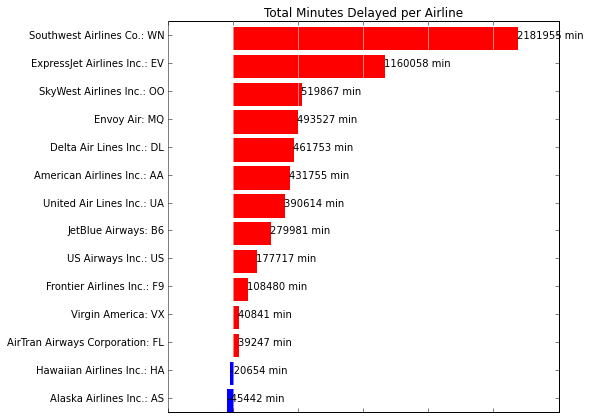

In [51]:
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(111)


airlines = [d[0] for d in delays]
minutes = [d[1] for d in delays]
index = list(xrange(len(airlines)))

bars = ax.barh(index, minutes)

for idx, air, mins in zip(index, airlines, minutes):
    if mins > 0:
        bars[idx].set_color("red")
        ax.annotate("{:0.0f} min".format(mins), xy=(mins+1, idx+0.5), va='center')
    else:
        bars[idx].set_color("blue")
        ax.annotate("{:0.0f} min".format(mins), xy=(mins+1, idx+0.5), va='center')
        
ax.set_yticks([idx + 0.5 for idx in index])
ax.set_yticklabels(airlines)
xt = ax.get_xticks()
ax.set_xticklabels([' ']*len(xt))
ax.grid(axis='x', color='white', linestyle='-')
ax.set_title("Total Minutes Delayed per Airline")

---
#Logistic Regression with Spark MLlib
---

##Python First

In [165]:
dat = pd.read_csv("../Data/sample_svm_data.txt", delimiter = ' ', header = None)

In [166]:
dat.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,0,2.520784,0,0,0,2.004684,2.000347,0,2.228387,2.228387,0,0,0,0,0,0


In [167]:
predictors = dat.columns.values[1:]
print predictors

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [168]:
X = dat[predictors]
y = dat[0]

In [169]:
clf_pySGD = SGDClassifier(loss='log', alpha = 0.01, n_iter = 10000)
clf_pySGD.fit(X, y)
yhat = clf_pySGD.predict(X)
print clf_pySGD.score(X, y)

0.636645962733


In [170]:
cm = pd.crosstab(y, yhat, rownames=["Actual"], colnames=["Predicted"])
cm

Predicted,0,1
Actual,,
0,101,59
1,58,104


---
##Spark
---

#####LabeledPoint is a built in Pyspark class (label, features)

In [175]:
def parse_point(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

In [176]:
data = sc.textFile("../Data/sample_svm_data.txt")

In [177]:
data.take(1)

[u'1 0 2.52078447201548 0 0 0 2.004684436494304 2.000347299268466 0 2.228387042742021 2.228387042742023 0 0 0 0 0 0']

#####Map into key value pairs

In [178]:
parsed_data = data.map(parse_point)

In [188]:
print type(parsed_data)
parsed_data.first()

<class 'pyspark.rdd.PipelinedRDD'>


LabeledPoint(1.0, [0.0,2.52078447202,0.0,0.0,0.0,2.00468443649,2.00034729927,0.0,2.22838704274,2.22838704274,0.0,0.0,0.0,0.0,0.0,0.0])

######Use the Spark logisitic regression model

In [180]:
spark_clf = LogisticRegressionWithSGD.train(parsed_data)

print type(spark_clf)

<class 'pyspark.mllib.classification.LogisticRegressionModel'>


#####p is a labelled point

In [216]:
labels_and_predictions = parsed_data.map(lambda p: (p.label, spark_clf.predict(p.features)))

In [217]:
print type(labels_and_predictions)
print labels_and_predictions.take(10)

<class 'pyspark.rdd.PipelinedRDD'>
[(1.0, 1), (0.0, 1), (0.0, 0), (1.0, 1), (1.0, 0), (0.0, 1), (1.0, 1), (1.0, 1), (0.0, 0), (0.0, 0)]


In [236]:
print parsed_data.count()

322


In [271]:
yyhat = labels_and_predictions.reduceByKey(lambda x, y: x + y).collect()
landp = labels_and_predictions.map(lambda x : (x[1], x[0]))
yyhat_1 = landp.reduceByKey(lambda x, y: x + y).collect()


print yyhat
print yyhat_1
print labels_and_predictions.filter(lambda (x, y): x != y).count()
print labels_and_predictions.filter(lambda (x, y): x == y).count()

[(0.0, 59), (1.0, 104)]
[(0, 58.0), (1, 104.0)]
117
205


In [264]:
results = list(labels_and_predictions.take(1000))
y = np.array([x[0] for x in results])
yhat = np.array([x[1] for x in results])

In [265]:
cm = pd.crosstab(y, yhat, rownames=["Actual"], colnames=["Predicted"])
cm

Predicted,0,1
Actual,,
0,101,59
1,58,104


In [266]:
training_error = labels_and_predictions.filter(lambda (v, p): v != p).count()/float(parsed_data.count())

In [267]:
print training_error

0.363354037267
